## Skeleton Code

The code below provides a skeleton for the model building & training component of your project. You can add/remove/build on code however you see fit, this is meant as a starting point.

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
from glob import glob
%matplotlib inline
import matplotlib.pyplot as plt
import sklearn.model_selection as skl
from random import sample
from keras.preprocessing.image import ImageDataGenerator
from itertools import chain 
from keras.applications.vgg16 import VGG16
from keras.models import Sequential,Model
from keras.layers import GlobalAveragePooling2D,Dense,Dropout,Flatten,Conv2D,MaxPooling2D
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint,LearningRateScheduler,EarlyStopping,ReduceLROnPlateau
from sklearn.metrics import roc_curve,auc,precision_recall_curve,average_precision_score,plot_precision_recall_curve,f1_score,confusion_matrix
##Import any other stats/DL/ML packages you may need here. E.g. Keras, scikit-learn, etc.

Using TensorFlow backend.


## Do some early processing of your metadata for easier model training:

In [2]:
## Below is some helper code to read all of your full image filepaths into a dataframe for easier manipulation
## Load the NIH data to all_xray_df
all_xray_df = pd.read_csv('/data/Data_Entry_2017.csv')
all_image_paths = {os.path.basename(x): x for x in 
                   glob(os.path.join('/data','images*', '*', '*.png'))}
print('Scans found:', len(all_image_paths), ', Total Headers', all_xray_df.shape[0])
all_xray_df['path'] = all_xray_df['Image Index'].map(all_image_paths.get)
all_xray_df.sample(3)

Scans found: 112120 , Total Headers 112120


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11,path
57855,00014330_000.png,No Finding,0,14330,39,F,PA,2696,2528,0.143,0.143,NaN,/data/images_007/images/00014330_000.png
29316,00007626_000.png,Effusion,0,7626,77,F,PA,2048,2500,0.168,0.168,NaN,/data/images_004/images/00007626_000.png
27816,00007240_000.png,No Finding,0,7240,76,F,PA,2048,2500,0.171,0.171,NaN,/data/images_004/images/00007240_000.png


In [3]:
## Here you may want to create some extra columns in your table with binary indicators of certain diseases 
## rather than working directly with the 'Finding Labels' column
all_labels=np.unique(list(chain(*all_xray_df['Finding Labels'].map(lambda x:x.split('|')).tolist())))
print('All Labels ({}):{}'.format(len(all_labels),all_labels))
all_labels=[x for x in all_labels if len(x)>0]
for labels in all_labels:
    all_xray_df[labels]=all_xray_df['Finding Labels'].map(lambda x:1.0 if labels in x else 0)

All Labels (15):['Atelectasis' 'Cardiomegaly' 'Consolidation' 'Edema' 'Effusion'
 'Emphysema' 'Fibrosis' 'Hernia' 'Infiltration' 'Mass' 'No Finding'
 'Nodule' 'Pleural_Thickening' 'Pneumonia' 'Pneumothorax']


In [4]:
## Here we can create a new column called 'pneumonia_class' that will allow us to look at 
## images with or without pneumonia for binary classification
all_xray_df['pneumonia_class']=all_xray_df['Pneumonia'].map(lambda x:1 if x==1.0 else 0).astype(str)
all_xray_df.head(5)
all_xray_df['pneumonia_class']=all_xray_df['Pneumonia'].replace(1.0,'pneumonia')
all_xray_df['pneumonia_class']=all_xray_df['pneumonia_class'].replace(0.0,'no pneumonia').astype(str)
all_xray_df.head(300)

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,...,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax,pneumonia_class
0,00000001_000.png,Cardiomegaly,0,1,58,M,PA,2682,2749,0.143,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,no pneumonia
1,00000001_001.png,Cardiomegaly|Emphysema,1,1,58,M,PA,2894,2729,0.143,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,no pneumonia
2,00000001_002.png,Cardiomegaly|Effusion,2,1,58,M,PA,2500,2048,0.168,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,no pneumonia
3,00000002_000.png,No Finding,0,2,81,M,PA,2500,2048,0.171,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,no pneumonia
4,00000003_000.png,Hernia,0,3,81,F,PA,2582,2991,0.143,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,no pneumonia
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
295,00000067_000.png,Fibrosis,0,67,62,F,PA,2992,2991,0.143,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,no pneumonia
296,00000067_001.png,Atelectasis,1,67,65,F,PA,2992,2991,0.143,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,no pneumonia
297,00000067_002.png,No Finding,2,67,66,F,PA,2992,2991,0.143,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,no pneumonia
298,00000068_000.png,No Finding,0,68,65,F,PA,2992,2991,0.143,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,no pneumonia


## Create your training and testing data:

In [5]:
def create_splits(dataframe):
    
    ## Either build your own or use a built-in library to split your original dataframe into two sets 
    ## that can be used for training and testing your model
    ## It's important to consider here how balanced or imbalanced you want each of those sets to be
    ## for the presence of pneumonia
    train_df,valid_df=skl.train_test_split(dataframe,test_size=0.2,stratify=dataframe['Pneumonia'])
    p_inds=train_df[train_df.pneumonia_class=='pneumonia'].index.tolist()
    np_inds=train_df[train_df.pneumonia_class=='no pneumonia'].index.tolist()
    np_sample=sample(np_inds,len(p_inds))
    train_data=train_df.loc[p_inds+np_sample]
    p_inds=valid_df[valid_df.pneumonia_class=='pneumonia'].index.tolist()
    np_inds=valid_df[valid_df.pneumonia_class=='no pneumonia'].index.tolist()
    np_sample=sample(np_inds,4*len(p_inds))
    val_data=valid_df.loc[p_inds+np_sample]
    return train_data, val_data


# Now we can begin our model-building & training

#### First suggestion: perform some image augmentation on your data

In [6]:
def my_image_augmentation(judge):
   
    ## recommendation here to implement a package like Keras' ImageDataGenerator
    ## with some of the built-in augmentations 
    
    ## keep an eye out for types of augmentation that are or are not appropriate for medical imaging data
    ## Also keep in mind what sort of augmentation is or is not appropriate for testing vs validation data
    
    ## STAND-OUT SUGGESTION: implement some of your own custom augmentation that's *not*
    ## built into something like a Keras package
    if (judge=='train'):
        my_idg=ImageDataGenerator(rescale=1./255.0,
                                 horizontal_flip=True,
                                 vertical_flip=False,
                                 height_shift_range=0.1,
                                 width_shift_range=0.1,
                                 rotation_range=20,
                                 shear_range=0.1,
                                 zoom_range=0.1
                                 )
    else:
        my_idg=ImageDataGenerator(rescale=1./255.0)
    
    return my_idg

train_df,valid_df=create_splits(all_xray_df)
my_train_idg=my_image_augmentation('train')
my_val_idg=my_image_augmentation('valid')
def make_train_gen(my_train_idg):
    
    
    ## Create the actual generators using the output of my_image_augmentation for your training data
    ## Suggestion here to use the flow_from_dataframe library, e.g.:
    
#     train_gen = my_train_idg.flow_from_dataframe(dataframe=train_df, 
#                                          directory=None, 
#                                          x_col = ,
#                                          y_col = ,
#                                          class_mode = 'binary',
#                                          target_size = , 
#                                          batch_size = 
#                                          )
    train_gen=my_train_idg.flow_from_dataframe(dataframe=train_df,
                                               directory=None,
                                               x_col='path',
                                               y_col='pneumonia_class',
                                               class_mode='binary',
                                               target_size=IMG_SIZE,
                                               batch_size=32
                                               )

    return train_gen


def make_val_gen(my_val_idg):
    
#     val_gen = my_val_idg.flow_from_dataframe(dataframe = val_data, 
#                                              directory=None, 
#                                              x_col = ,
#                                              y_col = ',
#                                              class_mode = 'binary',
#                                              target_size = , 
#                                              batch_size = ) 
    
    val_gen=my_val_idg.flow_from_dataframe(dataframe=valid_df,
                                          directory=None,
                                          x_col='path',
                                          y_col='pneumonia_class',
                                          class_mode='binary',
                                          target_size=IMG_SIZE,
                                          batch_size=32
                                          )
    return val_gen
IMG_SIZE=(224,224)
train_gen=make_train_gen(my_train_idg)
val_gen=make_val_gen(my_val_idg)

Found 2290 validated image filenames belonging to 2 classes.
Found 1430 validated image filenames belonging to 2 classes.


In [7]:
## May want to pull a single large batch of random validation data for testing after each epoch:
valX, valY = val_gen.next()
print(train_gen.class_indices)
print(valY)

{'no pneumonia': 0, 'pneumonia': 1}
[0. 1. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0.]


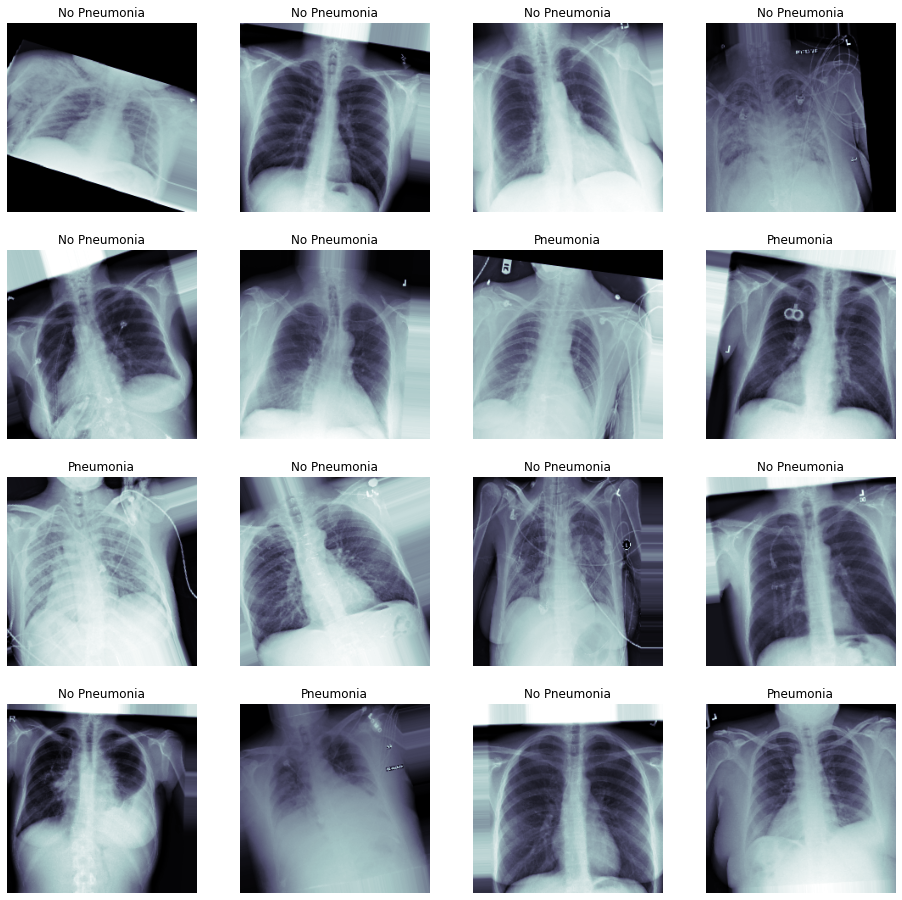

In [8]:
## May want to look at some examples of our augmented training data. 
## This is helpful for understanding the extent to which data is being manipulated prior to training, 
## and can be compared with how the raw data look prior to augmentation

t_x, t_y = next(train_gen)
fig, m_axs = plt.subplots(4, 4, figsize = (16, 16))
for (c_x, c_y, c_ax) in zip(t_x, t_y, m_axs.flatten()):
    c_ax.imshow(c_x[:,:,0], cmap = 'bone')
    if c_y == 1: 
        c_ax.set_title('Pneumonia')
    else:
        c_ax.set_title('No Pneumonia')
    c_ax.axis('off')

## Build your model: 

Recommendation here to use a pre-trained network downloaded from Keras for fine-tuning

In [9]:
def load_pretrained_model():
    
    # model = VGG16(include_top=True, weights='imagenet')
    # transfer_layer = model.get_layer(lay_of_interest)
    # vgg_model = Model(inputs = model.input, outputs = transfer_layer.output)
    model=VGG16(include_top=True,weights='imagenet')
    transfer_layer=model.get_layer('block5_pool')
    vgg_model=Model(inputs=model.input,outputs=transfer_layer.output)
    for layer in vgg_model.layers[0:17]:
        layer.trainable=False
    return vgg_model


In [10]:
def build_my_model(vgg_model):
    
    # my_model = Sequential()
    # ....add your pre-trained model, and then whatever additional layers you think you might
    # want for fine-tuning (Flatteen, Dense, Dropout, etc.)
    
    # if you want to compile your model within this function, consider which layers of your pre-trained model, 
    # you want to freeze before you compile 
    
    # also make sure you set your optimizer, loss function, and metrics to monitor
    
    
    my_model=Sequential()
    my_model.add(vgg_model)
    my_model.add(Flatten())
    my_model.add(Dropout(0.3))
    my_model.add(Dense(1024,activation='relu'))
    my_model.add(Dropout(0.3))
    my_model.add(Dense(512,activation='relu'))
    my_model.add(Dropout(0.5))
    my_model.add(Dense(256,activation='relu'))
    my_model.add(Dense(1,activation='sigmoid'))
    return my_model

vgg_model=load_pretrained_model()
my_model=build_my_model(vgg_model)

## STAND-OUT Suggestion: choose another output layer besides just the last classification layer of your modele
## to output class activation maps to aid in clinical interpretation of your model's results

553467904/553467096 [==============================] - 11s 0us/step


In [11]:
## Below is some helper code that will allow you to add checkpoints to your model,
## This will save the 'best' version of your model by comparing it to previous epochs of training

## Note that you need to choose which metric to monitor for your model's 'best' performance if using this code. 
## The 'patience' parameter is set to 10, meaning that your model will train for ten epochs without seeing
## improvement before quitting



weight_path="{}_my_model.best.hdf5".format('xray_class')

checkpoint = ModelCheckpoint(weight_path, 
                             monitor= 'val_loss', 
                             verbose=1, 
                             save_best_only=True, 
                             mode= 'min', 
                             save_weights_only = True)

early = EarlyStopping(monitor= 'val_loss', 
                       mode= 'min', 
                       patience=10)

callbacks_list = [checkpoint, early]

### Start training! 

In [12]:
## train your model

optimizer=Adam(lr=1e-4)
loss='binary_crossentropy'
metrics=['binary_accuracy']

my_model.compile(optimizer=optimizer,loss=loss,metrics=metrics)
history = my_model.fit_generator(train_gen, 
                          validation_data = (valX, valY), 
                          epochs =30 , 
                          callbacks = callbacks_list)

Epoch 1/30
72/72 [==============================] - 66s 915ms/step - loss: 0.7412 - binary_accuracy: 0.5301 - val_loss: 0.6335 - val_binary_accuracy: 0.6875

Epoch 00001: val_loss improved from inf to 0.63349, saving model to xray_class_my_model.best.hdf5
Epoch 2/30
72/72 [==============================] - 60s 836ms/step - loss: 0.6964 - binary_accuracy: 0.5642 - val_loss: 0.5799 - val_binary_accuracy: 0.8125

Epoch 00002: val_loss improved from 0.63349 to 0.57992, saving model to xray_class_my_model.best.hdf5
Epoch 3/30
72/72 [==============================] - 60s 837ms/step - loss: 0.6811 - binary_accuracy: 0.5852 - val_loss: 0.5350 - val_binary_accuracy: 0.7188

Epoch 00003: val_loss improved from 0.57992 to 0.53504, saving model to xray_class_my_model.best.hdf5
Epoch 4/30
72/72 [==============================] - 59s 823ms/step - loss: 0.6718 - binary_accuracy: 0.5948 - val_loss: 0.6428 - val_binary_accuracy: 0.5625

Epoch 00004: val_loss did not improve from 0.53504
Epoch 5/30
72/7

##### After training for some time, look at the performance of your model by plotting some performance statistics:

Note, these figures will come in handy for your FDA documentation later in the project

In [13]:
## After training, make some predictions to assess your model's overall performance
## Note that detecting pneumonia is hard even for trained expert radiologists, 
## so there is no need to make the model perfect.

my_model.load_weights(weight_path)
pred_Y = my_model.predict(valX, batch_size = 32, verbose = True)
print(pred_Y)

32/32 [==============================] - 0s 13ms/step
[[0.06627519]
 [0.40843675]
 [0.4930722 ]
 [0.31612965]
 [0.4645217 ]
 [0.45525506]
 [0.22406411]
 [0.4018783 ]
 [0.5794916 ]
 [0.29681763]
 [0.45398974]
 [0.3096248 ]
 [0.51772296]
 [0.24262494]
 [0.2852636 ]
 [0.23871404]
 [0.03985662]
 [0.10834029]
 [0.1989045 ]
 [0.07169302]
 [0.06288219]
 [0.020429  ]
 [0.39126217]
 [0.37664646]
 [0.38160503]
 [0.5582963 ]
 [0.05660799]
 [0.17528766]
 [0.4225921 ]
 [0.17091495]
 [0.2283012 ]
 [0.1501527 ]]


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Unrecognized location 'lowerleft'. Falling back on 'best'; valid locations are
	best
	upper right
	upper left
	lower left
	lower right
	right
	center left
	center right
	lower center
	upper center
	center
This will raise an exception in 3.3.


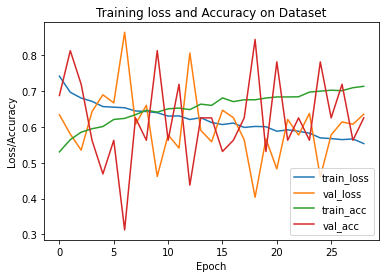

In [14]:
def plot_auc(t_y, p_y):
    
    ## Hint: can use scikit-learn's built in functions here like roc_curve
    fig,c_ax=plt.subplots(1,1,figsize=(9,9))
    fpr,tpr,thresholds=roc_curve(t_y,p_y)
    c_ax.plot(fpr,tpr,label='%s(AUC:%0.2f)'%('Pneumonia',auc(fpr,tpr)))
    c_ax.legend()
    c_ax.set_xlabel('False Positive Rate')
    c_ax.set_ylabel('True Positive Rate')


## what other performance statistics do you want to include here besides AUC? 


def plot_precision_recall_curve(t_y,p_y):
    fig,c_ax=plt.subplots(1,1,figsize=(9,9))
    precision,recall,thresholds=precision_recall_curve(t_y,p_y)
    c_ax.plot(recall,precision,label='%s(AP Score:%0.2f)'%('Pneumonia',average_precision_score(t_y,p_y)))
    c_ax.legend()
    c_ax.set_xlabel('Recall')
    c_ax.set_ylabel('Precision')
    return 2*(precision*recall)/(precision+recall)


    
#Also consider plotting the history of your model training
    
def plot_history(history):
    N=len(history.history['loss'])
    plt.figure
    plt.plot(np.arange(0,N),history.history['loss'],label='train_loss')
    plt.plot(np.arange(0,N),history.history['val_loss'],label='val_loss')
    plt.plot(np.arange(0,N),history.history['binary_accuracy'],label='train_acc')
    plt.plot(np.arange(0,N),history.history['val_binary_accuracy'],label='val_acc')
    plt.title('Training loss and Accuracy on Dataset')
    plt.xlabel('Epoch')
    plt.ylabel('Loss/Accuracy')
    plt.legend(loc='lowerleft')
    
plot_history(history)

array([0.34782609, 0.27272727, 0.28571429, 0.3       , 0.31578947,
       0.33333333, 0.35294118, 0.375     , 0.4       , 0.42857143,
       0.46153846, 0.33333333, 0.36363636, 0.4       , 0.44444444,
       0.5       , 0.28571429, 0.33333333, 0.4       , 0.        ])

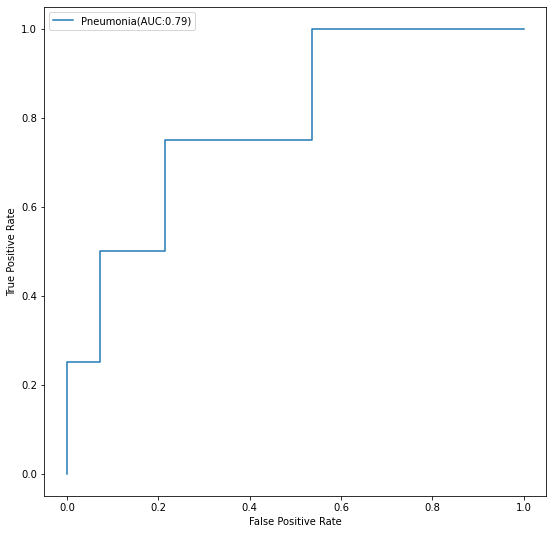

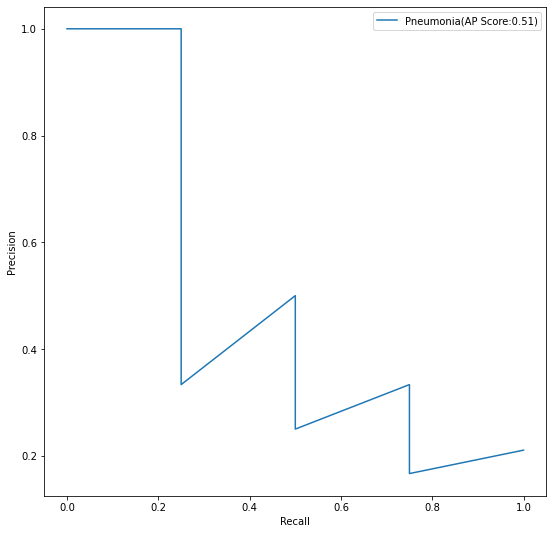

In [15]:
## plot figures

plot_auc(valY,pred_Y)
plot_precision_recall_curve(valY,pred_Y)

Once you feel you are done training, you'll need to decide the proper classification threshold that optimizes your model's performance for a given metric (e.g. accuracy, F1, precision, etc.  You decide) 

In [18]:
## Find the threshold that optimize your model's performance,
## and use that threshold to make binary classification. Make sure you take all your metrics into consideration.

precision,recall,thresholds=precision_recall_curve(valY,pred_Y)
precision_value=0.8
def calc_f1(prec,recall):
    return 2*(prec*recall)/(prec+recall)
idx=(np.abs(precision-precision_value)).argmin()
print('Precision is :'+ str(precision[idx]))
print('Recall is :'+str(recall[idx]))
print('Threshold is:'+str(thresholds[idx]))
print('F1 Score is:'+ str(calc_f1(precision[idx],recall[idx])))

recall_value=0.8
idx=(np.abs(recall-recall_value)).argmin()
print('Precision is:'+str(precision[idx]))
print('Recall is: '+str(recall[idx]))
print('Threshold is:'+str(thresholds[idx]))
print('F1 Score is'+str(calc_f1(precision[idx],recall[idx])))

probs=pd.DataFrame(pred_Y)
t1=(probs>0.69)
t2=(probs>0.39)
t1=t1.replace(True,1).replace(False,0)
t2=t2.replace(True,1).replace(False,0)
compare_t1=(t1==valY)
compare_t2=(t2==valY)
print('Accuracy at threshold 1:'+str(len(compare_t1[compare_t1])/len(pred_Y)))
print('Accuracy at threshold 2:'+str(len(compare_t2[compare_t2])/len(pred_Y)))

Precision is :1.0
Recall is :0.25
Threshold is:0.5794916
F1 Score is:0.4
Precision is:0.16666666666666666
Recall is: 0.75
Threshold is:0.24262494
F1 Score is0.27272727272727276


ValueError: Unable to coerce to Series, length must be 1: given 32

In [ ]:
## Let's look at some examples of true vs. predicted with our best model: 

# Todo

# fig, m_axs = plt.subplots(10, 10, figsize = (16, 16))
# i = 0
# for (c_x, c_y, c_ax) in zip(valX[0:100], testY[0:100], m_axs.flatten()):
#     c_ax.imshow(c_x[:,:,0], cmap = 'bone')
#     if c_y == 1: 
#         if pred_Y[i] > YOUR_THRESHOLD:
#             c_ax.set_title('1, 1')
#         else:
#             c_ax.set_title('1, 0')
#     else:
#         if pred_Y[i] > YOUR_THRESHOLD: 
#             c_ax.set_title('0, 1')
#         else:
#             c_ax.set_title('0, 0')
#     c_ax.axis('off')
#     i=i+1

In [ ]:
## Just save model architecture to a .json:

model_json = my_model.to_json()
with open("my_model.json", "w") as json_file:
    json_file.write(model_json)